In [1]:
pip install numpy pandas scikit-learn tensorflow keras


  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached ml_dtypes-0.4.1-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     -

In [9]:
pip install twilio

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


## Importing necessary libraries

In [41]:
import os
from twilio.rest import Client
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
from dotenv import load_dotenv, find_dotenv

# Check if the .env file is found
dotenv_path = find_dotenv(r'C:\Users\dasar\Desktop\lalitha_proj\.env')

if dotenv_path:
    print(f".env file found at {dotenv_path}")
    load_dotenv(dotenv_path)
else:
    print("No .env file found")


No .env file found


In [29]:
# === Securely Load Twilio Credentials ===
# Environment variable configuration
account_sid = os.getenv("dummy")
auth_token = os.getenv("dummy")
twilio_phone_number = os.getenv("+dummy")


# Ensure credentials are loaded
if not account_sid or not auth_token or not twilio_phone_number:
    raise ValueError("Twilio credentials are not properly set in environment variables!")

client = Client(account_sid, auth_token)

ValueError: Twilio credentials are not properly set in environment variables!

In [31]:
# Function to send an SOS SMS
def send_sos_sms(activity_name, confidence, phone_recipient="+1234567890"):
    message_body = (
        f"SOS Emergency Alert!\n"
        f"Abnormal activity detected.\n\n"
        f"Activity: {activity_name}\n"
        f"Confidence: {confidence:.2f}\n\n"
        f"Please take immediate action."
    )
    try:
        message = client.messages.create(
            body=message_body,
            from_=twilio_phone_number,
            to=phone_recipient
        )
        print(f"SOS SMS sent to {phone_recipient}. Message SID: {message.sid}")
    except Exception as e:
        print(f"Failed to send SOS SMS: {e}")

## Loading the dataset

In [17]:
def load_data():
    # Paths to the dataset
    train_data_path = "train/X_train.txt"
    train_labels_path = "train/y_train.txt"
    test_data_path = "test/X_test.txt"
    test_labels_path = "test/y_test.txt"
    
    # Load training and test data
    train_data = pd.read_csv(train_data_path, delim_whitespace=True, header=None)
    train_labels = pd.read_csv(train_labels_path, header=None)
    test_data = pd.read_csv(test_data_path, delim_whitespace=True, header=None)
    test_labels = pd.read_csv(test_labels_path, header=None)
    return train_data, train_labels, test_data, test_labels

# Load the data
train_data, train_labels, test_data, test_labels = load_data()


C:\Users\dasar\AppData\Local\Temp\ipykernel_11488\2197465927.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv(train_data_path, delim_whitespace=True, header=None)
C:\Users\dasar\AppData\Local\Temp\ipykernel_11488\2197465927.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv(test_data_path, delim_whitespace=True, header=None)


## Feature Correlation heatmap

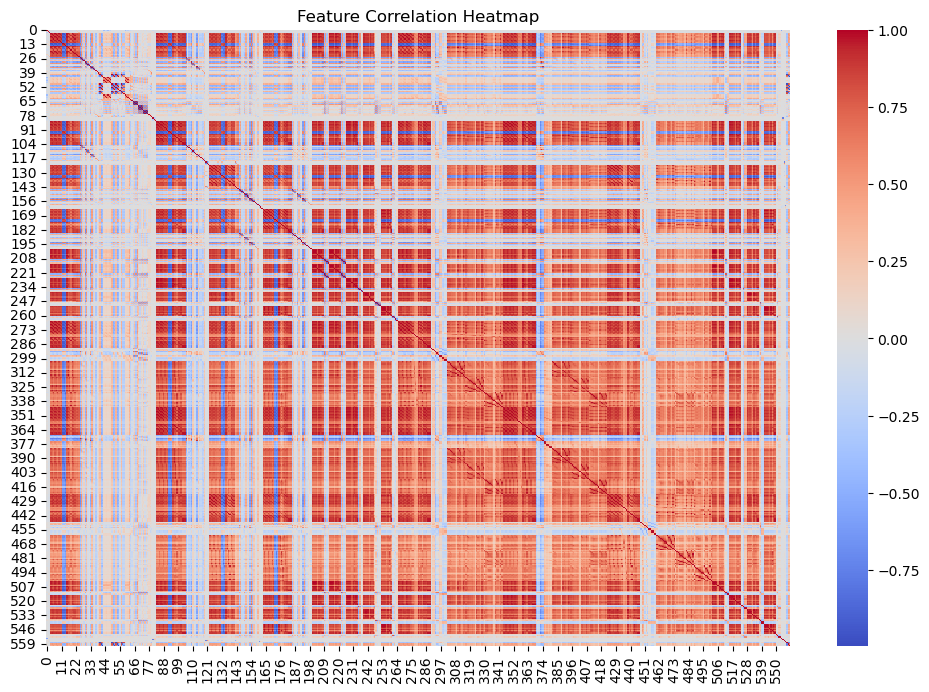

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations between features
correlations = train_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

## Processing the data

In [23]:
def preprocess_data(train_data, train_labels, test_data, test_labels):
    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_data)
    X_test = scaler.transform(test_data)
    
    # Encode labels
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(train_labels.values.ravel())
    y_test = encoder.transform(test_labels.values.ravel())
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    # Reshape input data to fit LSTM input (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    return X_train, y_train, X_test, y_test, encoder

# Preprocess the data
X_train, y_train, X_test, y_test, encoder = preprocess_data(train_data, train_labels, test_data, test_labels)

## Build the LSTM model

In [26]:
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define model parameters
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

# Build the model
model = build_model(input_shape, num_classes)
model.summary()

C:\Users\dasar\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 1, 128)              │         353,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 403,078 (1.54 MB)

 Trainable params: 403,078 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model using LSTM

In [29]:
lstm_history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6208 - loss: 1.1128 - val_accuracy: 0.9002 - val_loss: 0.2469
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9214 - loss: 0.2369 - val_accuracy: 0.9342 - val_loss: 0.1680
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9629 - loss: 0.1236 - val_accuracy: 0.9450 - val_loss: 0.1594
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9622 - loss: 0.1129 - val_accuracy: 0.9450 - val_loss: 0.1518
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9666 - loss: 0.0966 - val_accuracy: 0.9450 - val_loss: 0.1592
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9715 - loss: 0.0910 - val_accuracy: 0.9406 - val_loss: 0.1889
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9709 - loss: 0.0821 - val_accuracy: 0.9440 - val_loss: 0.1697
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9797 - loss: 0.0654 - val_accuracy:

In [30]:
print(sample_data[2])

NameError: name 'sample_data' is not defined

In [32]:
def detect_abnormal_activity(data_point, threshold=0.8):
    prediction = model.predict(data_point.reshape(1, 1, -1))
    max_prob = np.max(prediction)
    predicted_label = np.argmax(prediction)
    activity_name = encoder.inverse_transform([predicted_label])[0]
    
    if max_prob < threshold:
        print("Abnormal activity detected!")
    else:
        print(f"Detected activity: {activity_name} (confidence: {max_prob:.2f})")

# Test the function with a sample data point
sample_data = X_test[124]  # Replace with real-time or new data
detect_abnormal_activity(sample_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
Detected activity: 3 (confidence: 1.00)


## Building and training the model using RNN

In [35]:
from keras.layers import SimpleRNN

def build_rnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train the RNN model
rnn_model = build_rnn_model(input_shape, num_classes)
rnn_model.summary()
rnn_history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))


C:\Users\dasar\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 1, 128)              │          88,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,062 (394.77 KB)

 Trainable params: 101,062 (394.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5800 - loss: 1.0340 - val_accuracy: 0.8935 - val_loss: 0.2489
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8962 - loss: 0.2857 - val_accuracy: 0.9389 - val_loss: 0.1557
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9293 - loss: 0.1934 - val_accuracy: 0.9403 - val_loss: 0.1586
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9445 - loss: 0.1476 - val_accuracy: 0.9484 - val_loss: 0.1361
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9612 - loss: 0.1086 - val_accuracy: 0.9376 - val_loss: 0.1633
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9578 - loss: 0.1155 - val_accuracy: 0.9393 - val_loss: 0.1659
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9648 - loss: 0.0972 - val_accuracy: 0.9362 - val_loss: 0.1770
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9659 - loss: 0.0930 - val_accuracy: 0

## Training and validation accuracy plot for LSTM vs RNN

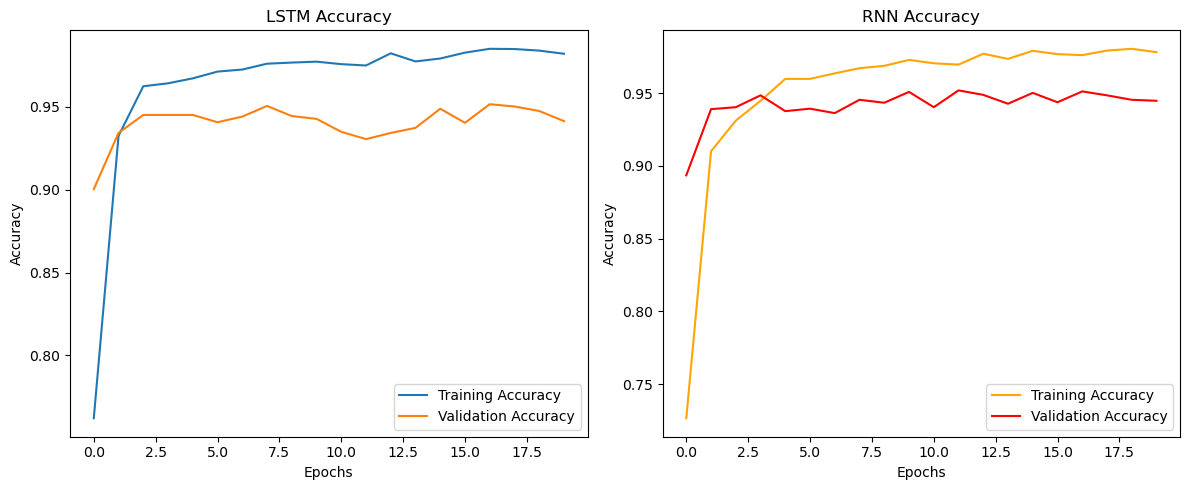

In [38]:
import matplotlib.pyplot as plt

# Function to plot accuracy comparison
def plot_accuracy_comparison(history_lstm, history_rnn):
    # Create a figure with subplots
    plt.figure(figsize=(12, 5))

    # LSTM Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
    plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
    plt.title("LSTM Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # RNN Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_rnn.history['accuracy'], label='Training Accuracy', color='orange')
    plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title("RNN Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot accuracy comparison
plot_accuracy_comparison(lstm_history, rnn_history)

## Training and validation loss plot

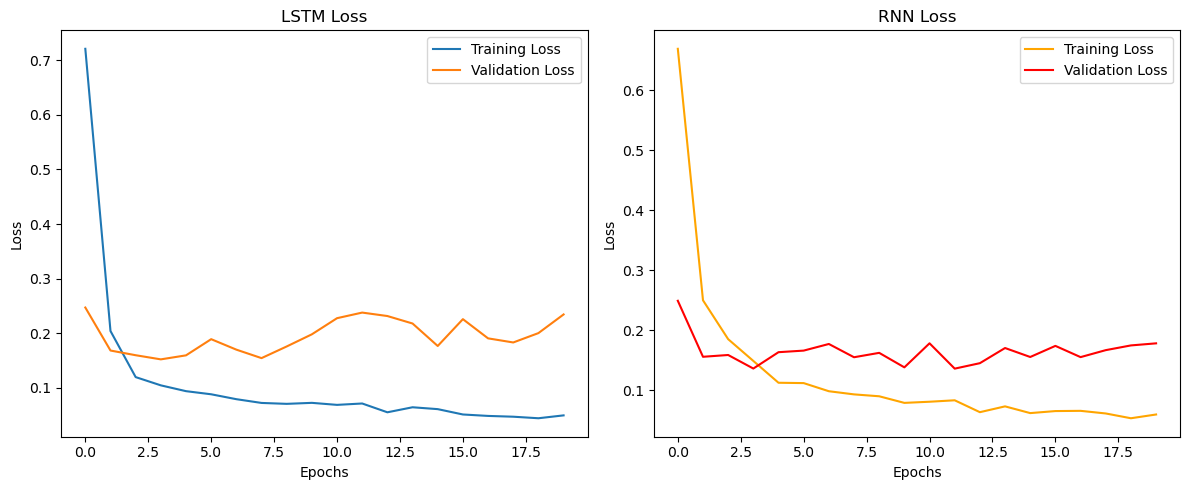

In [41]:
# Function to plot loss comparison
def plot_loss_comparison(history_lstm, history_rnn):
    # Create a figure with subplots
    plt.figure(figsize=(12, 5))

    # LSTM Loss
    plt.subplot(1, 2, 1)
    plt.plot(history_lstm.history['loss'], label='Training Loss')
    plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
    plt.title("LSTM Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # RNN Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_rnn.history['loss'], label='Training Loss', color='orange')
    plt.plot(history_rnn.history['val_loss'], label='Validation Loss', color='red')
    plt.title("RNN Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot loss comparison
plot_loss_comparison(lstm_history, rnn_history)


## Detecting abnormal activities

In [ ]:
# Update the detect_abnormal_activity function to include SMS alerts
def detect_abnormal_activity(data_point, threshold=0.8):
    prediction = model.predict(data_point.reshape(1, 1, -1))
    max_prob = np.max(prediction)
    predicted_label = np.argmax(prediction)
    activity_name = encoder.inverse_transform([predicted_label])[0]
    
    if max_prob < threshold:
        print("Abnormal activity detected!")
        send_sos_sms(activity_name, max_prob)
    else:
        print(f"Detected activity: {activity_name} (confidence: {max_prob:.2f})")

# Example usage
if __name__ == "__main__":
    # Load and preprocess data
    train_data, train_labels, test_data, test_labels = load_data()
    X_train, y_train, X_test, y_test, encoder = preprocess_data(train_data, train_labels, test_data, test_labels)
    
    # Build and train the model
    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = y_train.shape[1]
    model = build_model(input_shape, num_classes)
    model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))
    
    # Test SOS feature with a sample data point
    sample_data = X_test[124]
    detect_abnormal_activity(sample_data)

In [46]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# Function to send an SOS alert
def send_sos_alert(activity_name, confidence, email_recipient="emergency@example.com"):
    sender_email = "your_email@example.com"
    sender_password = "your_password"  # Use an app-specific password or token for better security.
    
    # Create the email content
    subject = "SOS Emergency Alert: Abnormal Activity Detected"
    body = (f"An abnormal activity was detected.\n\n"
            f"Activity: {activity_name}\n"
            f"Confidence: {confidence:.2f}\n\n"
            f"Please take immediate action.")
    
    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = email_recipient
    message["Subject"] = subject
    message.attach(MIMEText(body, "plain"))
    
    try:
        # Set up the server
        with smtplib.SMTP("smtp.gmail.com", 587) as server:
            server.starttls()
            server.login(sender_email, sender_password)
            server.sendmail(sender_email, email_recipient, message.as_string())
        print(f"SOS alert sent to {email_recipient}.")
    except Exception as e:
        print(f"Failed to send SOS alert: {e}")

# Update detect_abnormal_activity to include SOS alert
def detect_abnormal_activity(data_point, threshold=0.8):
    prediction = model.predict(data_point.reshape(1, 1, -1))
    max_prob = np.max(prediction)
    predicted_label = np.argmax(prediction)
    activity_name = encoder.inverse_transform([predicted_label])[0]
    
    if max_prob < threshold:
        print("Abnormal activity detected!")
        send_sos_alert(activity_name, max_prob)
    else:
        print(f"Detected activity: {activity_name} (confidence: {max_prob:.2f})")

# Test the SOS functionality
sample_data = X_test[124]  # Replace with real-time or new data
detect_abnormal_activity(sample_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Detected activity: 3 (confidence: 1.00)


In [56]:
from twilio.rest import Client

# Function to send an SMS SOS alert
def send_sos_sms(activity_name, confidence, phone_recipient="+18557056829"):
    # Twilio credentials (replace with your actual SID and token)
    account_sid = "ACe765389c6f0b295cb9d733f3e8583dd1"
    auth_token = "a69737f0f9be7d5a69e58b9f9e0427bb"
    twilio_phone_number = +18333669803  # E.g., "+1234567890"
    
    client = Client(account_sid, auth_token)
    
    message_body = (f"SOS Emergency Alert!\n"
                    f"Abnormal activity detected.\n\n"
                    f"Activity: {activity_name}\n"
                    f"Confidence: {confidence:.2f}\n\n"
                    f"Please take immediate action.")
    
    try:
        # Send the SMS
        message = client.messages.create(
            body=message_body,
            from_=twilio_phone_number,
            to=phone_recipient
        )
        print(f"SOS SMS sent to {phone_recipient}. Message SID: {message.sid}")
    except Exception as e:
        print(f"Failed to send SOS SMS: {e}")

# Update detect_abnormal_activity to include SMS alert
def detect_abnormal_activity(data_point, threshold=0.8):
    prediction = model.predict(data_point.reshape(1, 1, -1))
    max_prob = np.max(prediction)
    predicted_label = np.argmax(prediction)
    activity_name = encoder.inverse_transform([predicted_label])[0]
    
    if max_prob < threshold:
        print("Abnormal activity detected!")
        send_sos_sms(activity_name, max_prob)
    else:
        print(f"Detected activity: {activity_name} (confidence: {max_prob:.2f})")

# Test the SOS functionality
sample_data = X_test[124]  # Replace with real-time or new data
detect_abnormal_activity(sample_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Detected activity: 3 (confidence: 1.00)
